In [1]:
import sys
import flap

sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\utility")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\utility")
import convert_dict_to_flap
sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\core")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\core")
import core

INIT flap storage


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cmath

In [3]:
path = r"E:\marci main\fusion\inputdata\AUGD_35628_tor_bal_raw.sav"
print(path)

obj = core.NWTDataObject()
obj.load_raw_sav(path)

E:\marci main\fusion\inputdata\AUGD_35628_tor_bal_raw.sav


In [104]:
print(obj.raw_data.data.shape)
print(obj.raw_data.coordinates[0].data)
flap.list_data_objects(obj.raw_data)

(8, 40001)
<bound method Coordinate.data of <flap.coordinate.Coordinate object at 0x000001F9DC2C0E48>>

-----------------------------
<1>(data_source:"" exp_id:"AUGD-35628") data_title:"raw data" shape:[8,40001][no error]
  Data name:"unit", unit:"a.u."
  Coords:
    'Time [s](Dims:1, Shape:[40001]) [<R. symm.>] Val. range:  1.020E+00 -  1.040E+00
    'Channels [a.u.](Dims:0, Shape:[8]) [<R. symm.>] Val:MHI-B17-02, MHI-B31-40, MHI-B31-14, MHI-B31-03, MHI-B31-01, MHI-B31-02, MHI-B31-12, MHI-B31-13
    'Theta [rad](Dims:0, Shape:[8]) [<R. symm.>] Val: 5.962E+00,  5.905E+00,  5.985E+00,  5.990E+00,  5.995E+00,  5.981E+00,  5.973E+00,  5.986E+00
    'Phi [rad](Dims:0, Shape:[8]) [<R. symm.>] Val: 1.524E+00,  2.791E+00,  3.596E+00,  4.743E+00,  4.773E+00,  5.184E+00,  5.747E+00,  6.753E+00


'\n-----------------------------\n<1>(data_source:"" exp_id:"AUGD-35628") data_title:"raw data" shape:[8,40001][no error]\n  Data name:"unit", unit:"a.u."\n  Coords:\n    \'Time [s](Dims:1, Shape:[40001]) [<R. symm.>] Val. range:  1.020E+00 -  1.040E+00\n    \'Channels [a.u.](Dims:0, Shape:[8]) [<R. symm.>] Val:MHI-B17-02, MHI-B31-40, MHI-B31-14, MHI-B31-03, MHI-B31-01, MHI-B31-02, MHI-B31-12, MHI-B31-13\n    \'Theta [rad](Dims:0, Shape:[8]) [<R. symm.>] Val: 5.962E+00,  5.905E+00,  5.985E+00,  5.990E+00,  5.995E+00,  5.981E+00,  5.973E+00,  5.986E+00\n    \'Phi [rad](Dims:0, Shape:[8]) [<R. symm.>] Val: 1.524E+00,  2.791E+00,  3.596E+00,  4.743E+00,  4.773E+00,  5.184E+00,  5.747E+00,  6.753E+00'

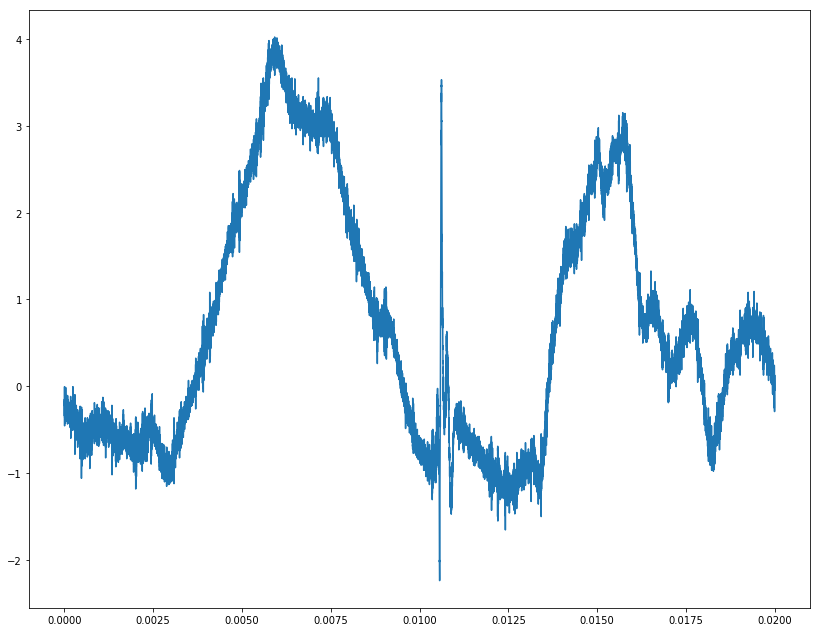

In [105]:
#%%script false
samples = obj.raw_data.data.shape[1]
#f=500
t=0.02
s_rate=t/samples
nyquist=s_rate/2

x = np.linspace(start=0,num=samples,stop=t)
data = obj.raw_data.data[1]
plt.figure(figsize=(14,11))
plt.plot(x,data)

# testing with generated data

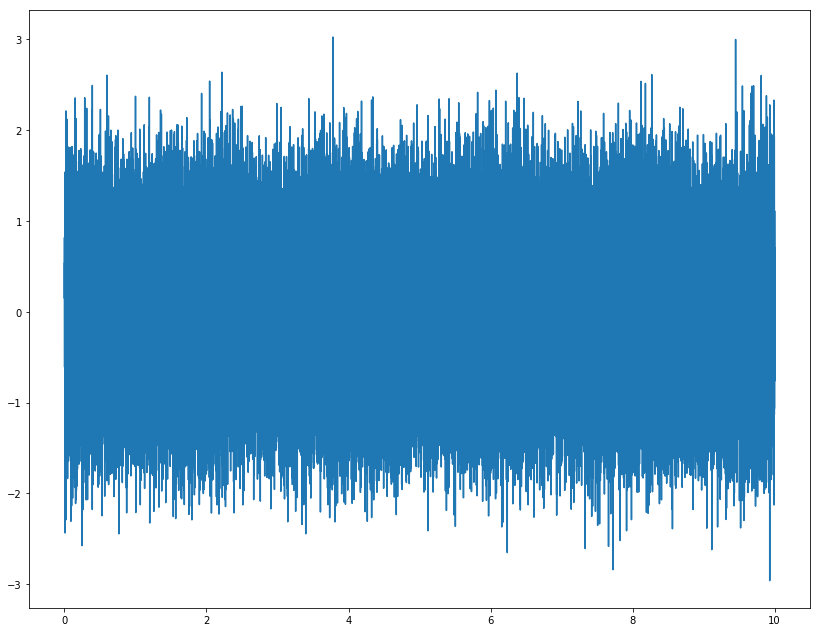

In [3]:
#%%script false
samples = 40000
f=500
s_rate=4000
t=samples/s_rate
nyquist=s_rate/2

x = np.linspace(start=0,num=samples,stop=t)
data = np.random.normal(0,0.5,samples)+1*np.sin(f*t*2*np.pi*x)
plt.figure(figsize=(14,11))
plt.plot(x,data)

In [4]:
n = int(2*samples**0.5)
len_fft = n
f_ax, t_ax, stft = scipy.signal.stft(data, nperseg=n, noverlap = n-1, nfft = len_fft)
stft=stft*2

In [5]:
#%%script false
search_r=10
ridgei=np.zeros(samples)
amplitude=np.zeros(samples,dtype=complex)
stft_abs=np.abs(stft)
ridgei[0]=np.argmax(stft_abs[:,0])

search_r=int(search_r)
for i in range(1,samples):
    if i%10000 == 0:
        print(ridgei[i-1])
    if ridgei[i-1] > search_r+1:
        ridgei[i]=np.argmax(stft_abs[int(ridgei[0])-search_r:int(ridgei[0])+search_r ,i])+ridgei[0]-search_r
    else: 
        ridgei[i]=np.argmax(stft_abs[0:int(ridgei[0])+search_r ,i])
    amplitude[i]=stft[int(ridgei[i]),i]
print(amplitude)
#print(ridgei)


100.0
100.0
100.0
[ 0.        +0.00000000e+00j  0.49540602+4.58333413e-04j
 -0.00050033+5.00470643e-01j ...  0.00927613+5.04986347e-01j
 -0.5001647 +9.48222414e-03j -0.00968669-4.95338682e-01j]


500.0
400 2000.0


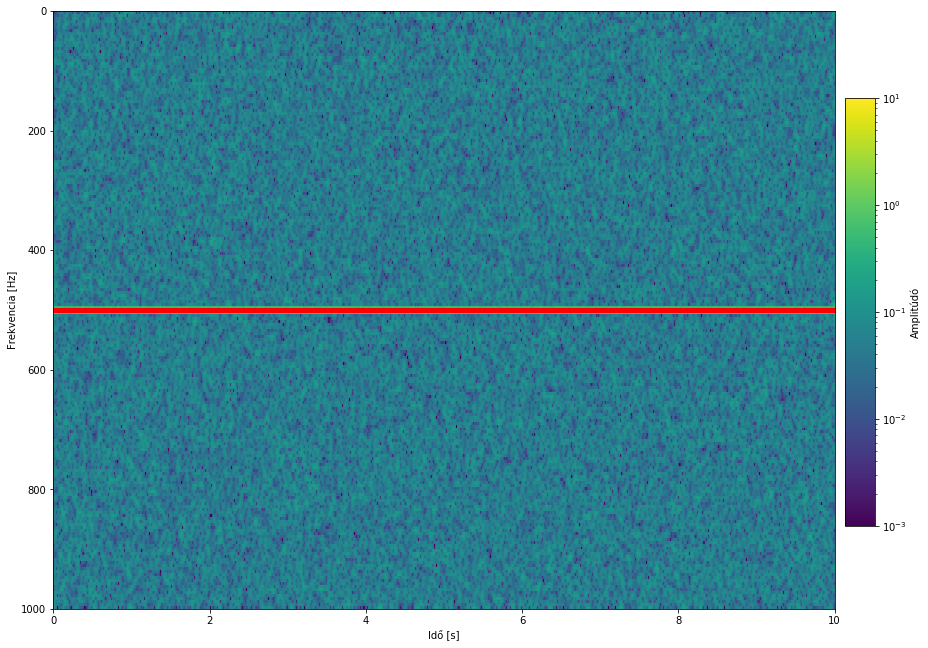

In [6]:
wievd=samples
wievf_i=len_fft
print(np.average(ridgei)/wievf_i*nyquist)
print(len_fft,nyquist)

import matplotlib.colors as colors
colornorm=colors.LogNorm(vmin=0.001, vmax=10)

plt.figure(figsize=(14,11))
plt.imshow(np.abs(stft[:wievf_i,:wievd]),aspect='auto',extent = [0,t,nyquist/2,0],norm=colornorm)# ,/len_fft*nyquist,0]
plt.plot(x,ridgei[:wievd]/wievf_i*nyquist,'r.-')#/len_fft*nyquist,"r.-"#*wievf*len_fft/s_rate
#plt.xlim(0,4)
plt.ylabel("Frekvencia [Hz]")
plt.xlabel("Idő [s]")
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
#plt.ylim(0,0.1)
plt.savefig("test-ridge")
plt.show()

0.08862007723996652


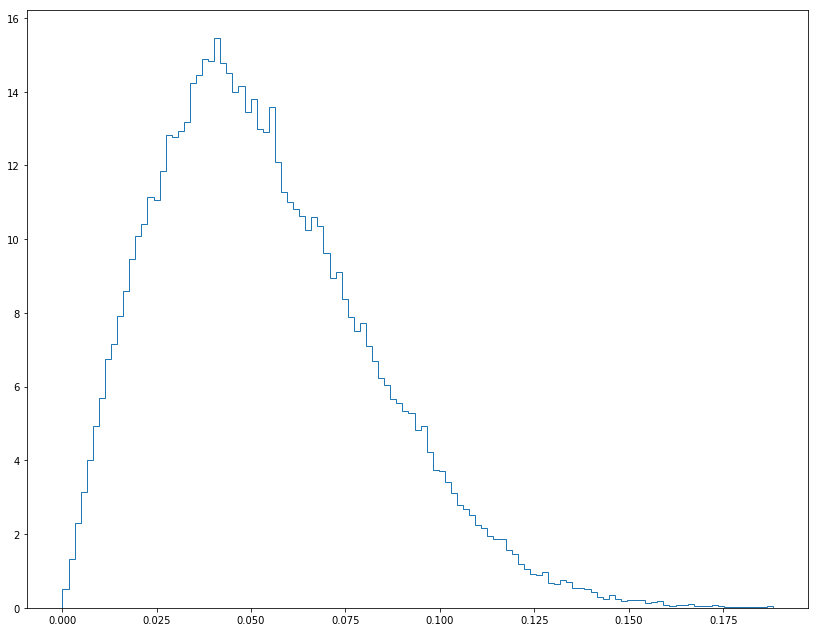

In [8]:
#c = np.abs(chosen).flatten()
#c = chosen.real.flatten()stft[0:15,0:1500]
print(amplitude[200])

#np.seterr(divide='ignore', invalid='ignore')
amplitude=np.abs(stft[10:20]).flatten()#int(np.average(ridgei))-25  

plt.figure(figsize=(14,11))
n, bins, patches = plt.hist(np.abs(amplitude), bins=117, density = True,facecolor='b',histtype='step')#4.2,4.7,range=(0.5,1.5)
#plt.xlim(4.2,4.7)
plt.savefig("test_hist")
plt.show()
dist_x=bins[:-1]

In [13]:
locg, stdg = scipy.stats.norm.fit(np.abs(amplitude))#,loc=0.5
print("normfit")
shape_r,loc_r,scale_r=scipy.stats.rice.fit(np.abs(amplitude))#,floc=0

normfit


In [14]:
print(locg,stdg)
print(shape_r,loc_r,scale_r)
print("Amplitúdó Rice eloszlással: ",shape_r*scale_r+loc_r, ",  Var: ", np.sqrt(scale_r))
print("Amplitúdó Gauss eloszlással: ",locg, ",  Var: ", np.sqrt(stdg))

0.053676981458495115 0.028617483142975627
0.0006308928402672252 -0.0001886677064274146 0.043130429040672075
Amplitúdó Rice eloszlással:  -0.00016145702754800099 ,  Var:  0.2076786677554343
Amplitúdó Gauss eloszlással:  0.053676981458495115 ,  Var:  0.169167027351596


Zaj:
0.05388128799561231 0.028243855123431433
0.0012425123713100464 0 0.04301689031333428
Amplitúdó Rice eloszlással:  5.3449018389605135e-05
Amplitúdó Gauss eloszlással:  0.05388128799561231 ,  Var:  0.16805908224023905

Jel:
0.9938795615182778 0.049566682596736786
20.013851182443467 0 0.04959763968882898
Amplitúdó Rice eloszlással:  0.9926397797326749
Amplitúdó Gauss eloszlással:  0.9938795615182778 ,  Var:  0.22263576216937114

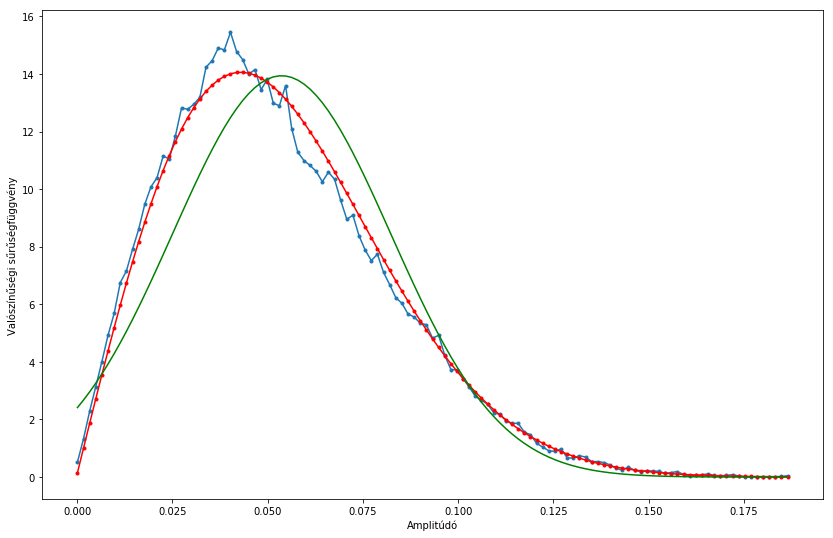

In [15]:
plt.figure(figsize=(14,9))
plt.plot(dist_x,n,'.-')
plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
plt.plot(dist_x,scipy.stats.norm.pdf(dist_x,loc=locg,scale=stdg),'g-') 
#plt.xlim(0.7,1.3)
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.savefig("teszt-rician-fit")
plt.show()

In [13]:
%%script false
max = np.max(np.abs(stft))
plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.abs(stft), vmin=0, vmax=max, shading='plasma')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_abs")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.real, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Real')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_real")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.imag, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Imag')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_imag")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.angle(stft), vmin=-6, vmax=6, shading='plasma')
plt.title('STFT Phase')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_phase")
plt.show()

Couldn't find program: 'false'


In [14]:
%%script false
shape_h=25
scale_h=25
loc_h=18
diff = np.zeros((shape_h,scale_h,loc_h))
shape = np.linspace(0,8,shape_h)
scale = np.linspace(0.04,0.10,scale_h)
loc = np.linspace(0.0,0.6,loc_h)
for i in range(shape_h):
    for j in range(scale_h):
        for k in range(loc_h):
            diff[i,j,k] = np.average((scipy.stats.rice.pdf(dist_x,shape[i],loc[k],scale[j])-n)**2)
    if i%2 == 0:
        print(i)
#print(divmod(diff.argmin(), diff.shape[1]))

#mini = np.min(diff)
x1,y1,z1=np.unravel_index(diff.argmin(), diff.shape)
print(x1,y1,z1)
print(shape[x1],scale[y1],loc[z1])

plt.figure(figsize=(14,11))
plt.imshow(diff[:,:,z1],aspect='auto')
plt.plot(y1,x1,'ro')
plt.ylabel("shape")
plt.xlabel("scale")
plt.show()

Couldn't find program: 'false'
